# Intro to Geospatial Data using Python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Reading the Data
The geopandas library can read almost any vector-based spatial data format including ESRI shapefile and GeoJSON files.
<br>
**NOTE:** This might take some time.

In [2]:
import geopandas as gpd

hennepin = gpd.read_file('data/MetroGIS_Tax_Parcels_2014/Parcels2014Hennepin.dbf')
hennepin.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 427762 entries, 0 to 427761
Data columns (total 70 columns):
Shape_Leng    427762 non-null float64
COUNTY_ID     427762 non-null object
PIN           427762 non-null object
BLDG_NUM      427762 non-null object
PREFIX_DIR    0 non-null object
PREFIXTYPE    0 non-null object
STREETNAME    427762 non-null object
STREETTYPE    0 non-null object
SUFFIX_DIR    0 non-null object
UNIT_INFO     51470 non-null object
CITY          427762 non-null object
CITY_USPS     414475 non-null object
ZIP           427762 non-null object
ZIP4          0 non-null object
PLAT_NAME     426333 non-null object
BLOCK         305269 non-null object
LOT           290705 non-null object
ACRES_POLY    427762 non-null float64
ACRES_DEED    427762 non-null float64
USE1_DESC     426337 non-null object
USE2_DESC     4398 non-null object
USE3_DESC     752 non-null object
USE4_DESC     207 non-null object
MULTI_USES    0 non-null object
LANDMARK      0 non-null obje

## Exploring Data
The dataset is using lots of memory. Let's check to make sure that all of the PIN values are unique and let's make sure to count NULL values in that list.

In [3]:
hennepin['PIN'].nunique(dropna=True) / len(hennepin['PIN'])

1.0

They are all unique. Now set the index so that we can traverse faster.

In [4]:
hennepin = hennepin.set_index(['PIN']).sort_index()

Now let us try to reduce memory usage by the data.

A lot of the fields are ``object`` type, which defaults to ``str`` on import. ``str`` is a not efficient, it contains a ton of additional methods like ``len()``, ``replace()``, etc. Additionally, they take up more space in memory as noted above.

Let's find how many object columns there are.

In [5]:
column_list = list(hennepin.select_dtypes(include=['object']).columns.values)
len(column_list)

54

I don't really want to go through each of the 54 columns so let's create a function that looks for columns where the number of unique values is less than 20% of the total row count. Data that has this property is said to have 'low cardinality'.

If we find a column that has low cardinality, let's convert them to ``category`` type.

In [6]:
def convert_to_categorical(df, cols):
    for col in cols:
        unique_vals = len(df[col].unique())
        unique_ratio = unique_vals / len(df)
        if unique_ratio <= 0.2:
            df[col] = df[col].astype('category')
    return df

In [7]:
hennepin = convert_to_categorical(hennepin, column_list)

TypeError: unhashable type: 'Polygon'

In [8]:
hennepin.head()

,Shape_Leng,COUNTY_ID,BLDG_NUM,PREFIX_DIR,PREFIXTYPE,STREETNAME,STREETTYPE,SUFFIX_DIR,UNIT_INFO,CITY,...,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,PARC_CODE,TORRENS,Shape_Le_1,Shape_Area,geometry
PIN,,,,,,,,,,,,,,,,,,,,,
053-0102724110003,1298.619232,053,2901,NaN,NaN,78TH ST E,NaN,NaN,NaN,BLOOMINGTON,...,N,N,N,NaN,NaN,0,T,395.645416,7416.662441,"POLYGON ((481758.6119 4967622.9012, 481758.294..."
053-0102724110004,1388.057469,053,7800,NaN,NaN,METRO PKWY,NaN,NaN,NaN,BLOOMINGTON,...,N,N,N,NaN,NaN,0,T,422.894044,7676.706709,"POLYGON ((481827.7642 4967621.7611, 481887.776..."
053-0102724110005,1400.082610,053,7850,NaN,NaN,METRO PKWY,NaN,NaN,NaN,BLOOMINGTON,...,N,N,N,NaN,NaN,0,B,426.557685,6399.614332,"POLYGON ((481827.4471 4967582.1543, 481827.105..."
053-0102724110006,1383.510634,053,2950,NaN,NaN,METRO DR,NaN,NaN,NaN,BLOOMINGTON,...,N,N,N,NaN,NaN,0,B,421.502025,7184.857320,"POLYGON ((481799.116 4967582.6214, 481798.5232..."
053-0102724110008,1388.369487,053,7801,NaN,NaN,METRO PKWY,NaN,NaN,NaN,BLOOMINGTON,...,N,N,N,NaN,NaN,0,T,422.989308,7681.696608,"POLYGON ((482035.2701 4967618.3399, 482035.265..."


``convert_to_categorical()`` failed at ``geometry`` column. Let's try again without this column.

In [9]:
column_list = list(hennepin.select_dtypes(include=['object']).columns.values)
column_list.remove('geometry')
hennepin = convert_to_categorical(hennepin, column_list)

In [10]:
hennepin.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 427762 entries, 053-0102724110003 to 053-3612123410019
Data columns (total 69 columns):
Shape_Leng    427762 non-null float64
COUNTY_ID     427762 non-null category
BLDG_NUM      427762 non-null category
PREFIX_DIR    0 non-null category
PREFIXTYPE    0 non-null category
STREETNAME    427762 non-null category
STREETTYPE    0 non-null category
SUFFIX_DIR    0 non-null category
UNIT_INFO     51470 non-null category
CITY          427762 non-null category
CITY_USPS     414475 non-null category
ZIP           427762 non-null category
ZIP4          0 non-null category
PLAT_NAME     426333 non-null category
BLOCK         305269 non-null category
LOT           290705 non-null category
ACRES_POLY    427762 non-null float64
ACRES_DEED    427762 non-null float64
USE1_DESC     426337 non-null category
USE2_DESC     4398 non-null category
USE3_DESC     752 non-null category
USE4_DESC     207 non-null category
MULTI_USES    0 non-null category
LAND

That more than halved our memory consumption!

## Profiling

Let's get some summary stats on our data. This takes time to run but gives great amount of summary than ``describe()``.

In [ ]:
import pandas_profiling
pandas_profiling.ProfileReport(hennepin.select_dtypes(exclude=['object']))

No point in keeping constant columns in the data. Let's remove them.

In [31]:
drop_cols = ['AGPRE_ENRD', 'AGPRE_EXPD', 'COUNTY_ID', 'DWELL_TYPE', 'LANDMARK', 'MULTI_USES', 
             'NUM_UNITS', 'OWNER_MORE', 'OWN_ADD_L1', 'OWN_ADD_L2', 'OWN_ADD_L3', 'PARC_CODE', 
             'PREFIXTYPE', 'PREFIX_DIR', 'STREETTYPE', 'SUFFIX_DIR', 'ZIP4']
hennepin = hennepin.drop(drop_cols, axis=1)

## Missing Data

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


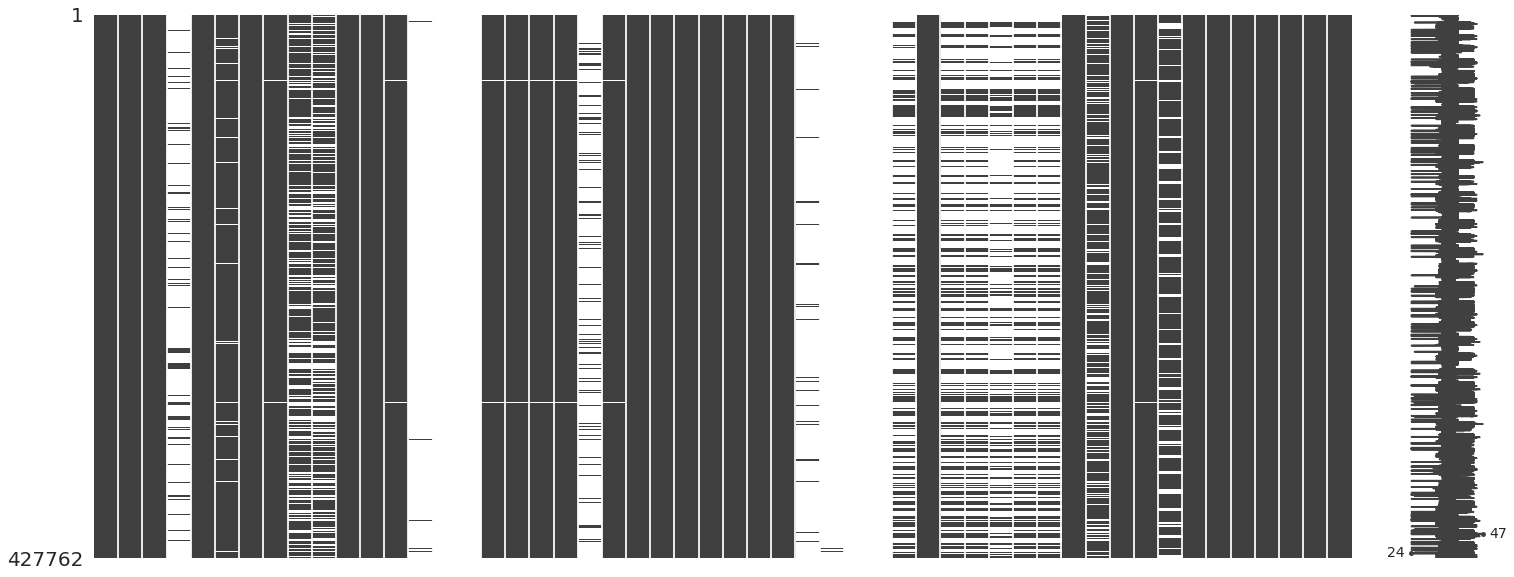

In [32]:
import missingno as msno

msno.matrix(hennepin)

Some columns are barely populated. Let's remove them if they are less than 1% populated.

In [33]:
def delete_near_null(df, cols, populated_threshold=0.01):
    for col in cols:
        non_null_rows = df[col].count()
        total_rows = len(df[col])
        populated_ratio = non_null_rows/total_rows
        if populated_ratio <= populated_threshold:
            del df[col]
    return df

In [34]:
column_list = list(hennepin.columns.values)
column_list.remove('geometry')
hennepin = delete_near_null(hennepin, column_list)

In [35]:
hennepin.shape

(427762, 47)

## Filtering on Geodesic features

The dataset may have ``Point`` information.

These are sometimes there to help break up condos into individually owned units and tax each seperately. For ease of use and sanity I'm going to exclude them.

You can also have the following ``geom_types``:
* Points / Multi-Points
* Lines / Multi-Lines
* Polygons / Multi-Polygons

In [36]:
# filter out points
hennepin = hennepin[hennepin['geometry'].geom_type != 'Point']

Geospatial Joins and Searchs are computationally expensive. For this example we will just do Minneapolis.

In [37]:
mnpls = hennepin[hennepin['CITY'] == 'MINNEAPOLIS']

In [38]:
mnpls.shape

(129889, 47)